In this notebook I'm going to split the data. The strategy is time-split as per requirement. After splitting remember to examine target distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
import ivpk

RDKit WARNING: [10:40:49] Enabling RDKit 2019.09.3 jupyter extensions


## Data inspection

First check full dataset.

In [3]:
df = ivpk.data.processed_df

In [4]:
df.columns

Index(['Name', 'SMILES', 'human VDss (L/kg)', 'human CL (mL/min/kg)',
       'fraction unbound \nin plasma (fu)', 'MRT (h)', 'terminal  t1/2 (h)',
       'Year of first disclosure', 'moka_ionState7.4', 'MoKa.LogP',
       'MoKa.LogD7.4', 'HBA', 'HBD', 'RotBondCount', 'MW', 'TPSA_NO'],
      dtype='object')

In [5]:
df.describe()

,human VDss (L/kg),human CL (mL/min/kg),fraction unbound \nin plasma (fu),MRT (h),terminal t1/2 (h),Year of first disclosure,MoKa.LogP,MoKa.LogD7.4,HBA,HBD,RotBondCount,MW,TPSA_NO
count,1300.000000,1335.000000,909.000000,1294.000000,1320.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.00000,1337.000000,1337.000000,1337.000000
mean,3.869653,12.318805,0.345102,17.337489,17.166407,1975.336574,1.658139,0.112104,7.178758,2.48018,6.066567,8.609909,6.468858
std,20.904023,48.990490,0.340138,74.714819,72.195522,23.553966,2.906150,3.362188,3.833968,1.96902,3.643865,0.764524,1.170177
min,0.030000,0.003700,0.000200,0.010000,0.020000,1878.000000,-9.000000,-9.000000,0.000000,0.00000,0.000000,5.427606,0.000000
25%,0.300000,1.700000,0.050000,1.745000,1.800000,1963.000000,0.210000,-1.600000,4.000000,1.00000,3.000000,8.162442,5.889960
50%,0.940000,4.700000,0.200000,4.000000,4.410000,1980.000000,2.000000,0.710000,6.000000,2.00000,5.000000,8.533485,6.485427
75%,2.662500,11.000000,0.650000,11.000000,12.000000,1992.000000,3.500000,2.300000,9.000000,3.00000,8.000000,8.911572,7.053111
max,700.000000,1070.000000,1.000000,1400.000000,1344.000000,2012.000000,9.000000,9.000000,15.000000,7.00000,13.000000,12.786043,11.500294


Check the splitting standard: year of first disclosure.

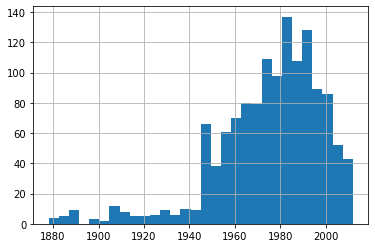

In [6]:
df["Year of first disclosure"].hist(bins=30)

In [7]:
(df["Year of first disclosure"]>=2000).value_counts()

False    1174
True      163
Name: Year of first disclosure, dtype: int64

Let's see if the target distribution changes.

In [8]:
train_val_df = df.loc[df["Year of first disclosure"]<2000, ]
test_df = df.loc[df["Year of first disclosure"]>=2000, ]

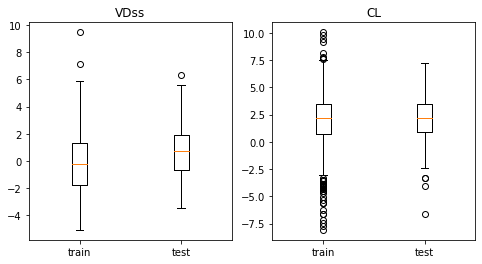

In [9]:
plt.figure(figsize=(8, 4))
for i,tar in enumerate(("VDss", "CL")):
    vals_train = ivpk.data.get_processed_y(
        target=tar, 
        df=train_val_df, 
    )
    vals_test = ivpk.data.get_processed_y(
        target=tar, 
        df=test_df, 
    )
    plt.subplot(1, 2, i+1)
    plt.boxplot(np.array([vals_train, vals_test], dtype=object))
    plt.xticks(ticks=[1, 2], labels=["train", "test"])
    plt.title(f"{tar}")
plt.show()


Although mean VDss is higher in test set, overall distribution has no obvious time-dependancy, just as the article concluded:
> "does not seem to indicate any particular trend for the first two properties"

Let's check the X variables.

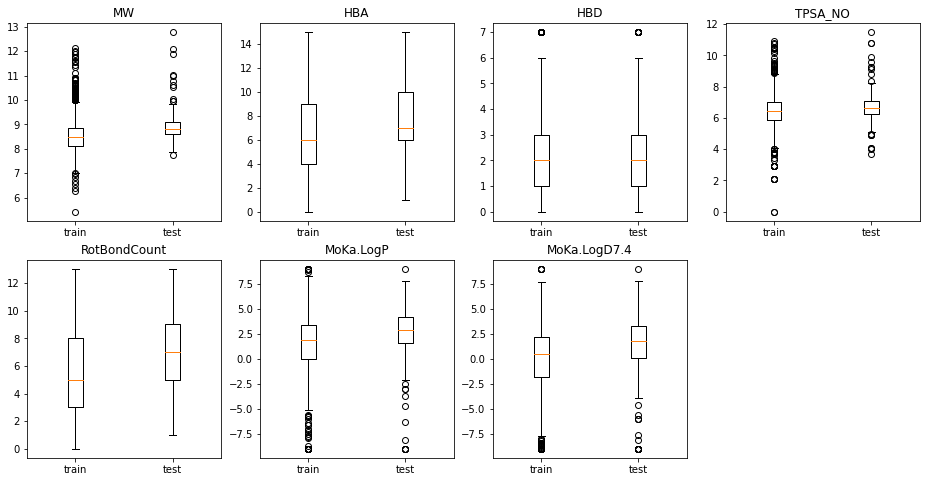

In [10]:
x_cols = [
    'MW', 'HBA', 'HBD', 'TPSA_NO', 'RotBondCount', 
    'moka_ionState7.4', 'MoKa.LogP', 'MoKa.LogD7.4'
]
plt.figure(figsize=(16, 8))
for i, colname in enumerate((
    'MW', 'HBA', 'HBD', 'TPSA_NO', 'RotBondCount', 'MoKa.LogP', 'MoKa.LogD7.4'
)):
    vals_train = train_val_df[colname]
    vals_test = test_df[colname]
    plt.subplot(2, 4, i+1)
    plt.boxplot(np.array([vals_train, vals_test], dtype=object))
    plt.xticks(ticks=[1, 2], labels=["train", "test"])
    plt.title(f"{colname}")
plt.show()

Trend of molecular weight is higher in test, which also affected HBA and RotBondCount. Distribution of LogD and LogP also increased overtime.  
The effect of input drift can be discussed when we **diagnose model performance**.

Now check the categorical variable "moka_ionState7.4". Make sure all 4 classes exist in both train and test.

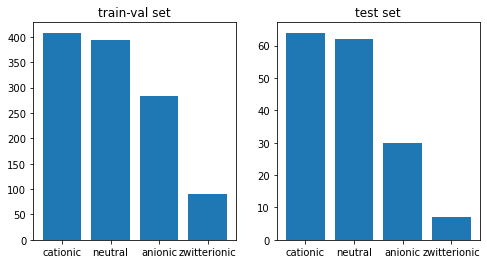

In [11]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.bar(
    x=train_val_df['moka_ionState7.4'].value_counts().index, 
    height=train_val_df['moka_ionState7.4'].value_counts())
plt.title("train-val set")
plt.subplot(122)
plt.bar(
    x=test_df['moka_ionState7.4'].value_counts().index, 
    height=test_df['moka_ionState7.4'].value_counts())
plt.title("test set")
plt.show()

## Split data

First let's split the train_val with the test set. Here I've set a baseline data preprocessing as using Morgan fingerprints at 256 dimension. 

In [12]:
fp_args = dict(fpType='morgan', fpSize=256)

To include the SMILES in later input, we **set x as a 2-element tuple**, first element the 2d array of computed attributes and fingerprints, shape (N, W), dtype float64, second element the array of smiles, shape (N, ), dtype object.

In [13]:
vdss_train_val_x, vdss_train_val_y = ivpk.data.get_x_y(
    target='VDss', df=train_val_df, 
    **fp_args
)

In [14]:
print(vdss_train_val_x[0].shape, vdss_train_val_x[1].shape)

(1143, 267) (1143,)


In [15]:
vdss_test_x, vdss_test_y = ivpk.data.get_x_y(
    target='VDss', df=test_df, 
    **fp_args
)

In [16]:
cl_train_val_x, cl_train_val_y = ivpk.data.get_x_y(
    target='CL', df=train_val_df, 
    **fp_args
)

In [17]:
cl_test_x, cl_test_y = ivpk.data.get_x_y(
    target='CL', df=test_df, 
    **fp_args
)

Let's also split the train-val set at a 8:2 ratio in case K-fold CV is not needed. Here I've **fixed the random state to 42 for reproducibility**.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
(
    vdss_train_x_0, vdss_val_x_0, vdss_train_x_1, vdss_val_x_1, 
    vdss_train_y, vdss_val_y
) = train_test_split(
    vdss_train_val_x[0], vdss_train_val_x[1], vdss_train_val_y, test_size=0.2, random_state=42
)

In [20]:
for arr in (
    vdss_train_x_0, vdss_train_x_1, vdss_train_y, 
    vdss_val_x_0, vdss_val_x_1, vdss_val_y
):
    print(arr.shape)

(914, 267)
(914,)
(914,)
(229, 267)
(229,)
(229,)


In [21]:
(
    cl_train_x_0, cl_val_x_0, cl_train_x_1, cl_val_x_1, 
    cl_train_y, cl_val_y
) = train_test_split(
    cl_train_val_x[0], cl_train_val_x[1], cl_train_val_y, test_size=0.2, random_state=42
)

In [22]:
for arr in (
    cl_train_x_0, cl_train_x_1, cl_train_y, 
    cl_val_x_0, cl_val_x_1, cl_val_y
):
    print(arr.shape)

(938, 267)
(938,)
(938,)
(235, 267)
(235,)
(235,)


Wrap the full dataset method.

In [23]:
#for arr in ivpk.data.all_datasets("VDss", validation_size=0.4, fpSize=128):
#for arr in ivpk.data.all_datasets("VDss", validation_size=None, fpSize=128):
#for arr in ivpk.data.all_datasets("VDss", validation_size=0.4, smiles_func=None):
for d in ivpk.data.all_datasets("CL", fpType='rdkit', fpSize=512):
    if isinstance(d, tuple):
        print(f"({d[0].shape}, {d[1].shape})")
    else:
        print(d.shape)
            


((938, 523), (938,))
(938,)
((235, 523), (235,))
(235,)
((162, 523), (162,))
(162,)


Now let's save the baseline data for easy reuse in modeling experiments.

In [24]:
import pickle

In [25]:
with open("data/baseline_VDss.pkl", "wb") as f:
    pickle.dump(dict(
        target = "VDss", 
        x_train = (vdss_train_x_0, vdss_train_x_1), 
        y_train = vdss_train_y,
        x_train_val = vdss_train_val_x, 
        y_train_val = vdss_train_val_y,
        x_val = (vdss_val_x_0, vdss_val_x_1),
        y_val = vdss_val_y,
        x_test = vdss_test_x, 
        y_test = vdss_test_y,
        **fp_args
    ), f)

In [27]:
with open("data/baseline_CL.pkl", "wb") as f:
    pickle.dump(dict(
        target = "CL", 
        x_train = (cl_train_x_0, cl_train_x_1), 
        y_train = cl_train_y,
        x_train_val = cl_train_val_x, 
        y_train_val = vdss_train_val_y,
        x_val = (cl_val_x_0, cl_val_x_1),
        y_val = cl_val_y,
        x_test = cl_test_x, 
        y_test = cl_test_y,
        **fp_args
    ), f)

Check loading the data from pickle:

In [28]:
with open("data/baseline_CL.pkl", "rb") as f:
    data = pickle.load(f)
data.keys()

dict_keys(['target', 'x_train', 'y_train', 'x_train_val', 'y_train_val', 'x_val', 'y_val', 'x_test', 'y_test', 'fpType', 'fpSize'])

In [31]:
for k,v in data.items():
    if isinstance(v, np.ndarray):
        print(f"{k}: shape {v.shape}")
    elif isinstance(v, tuple):
        print(f"{k}: shape ({v[0].shape}, {v[1].shape})")
    else:
        print(f"{k}: {v}")

target: CL
x_train: shape ((938, 267), (938,))
y_train: shape (938,)
x_train_val: shape ((1173, 267), (1173,))
y_train_val: shape (1143,)
x_val: shape ((235, 267), (235,))
y_val: shape (235,)
x_test: shape ((162, 267), (162,))
y_test: shape (162,)
fpType: morgan
fpSize: 256


If we only want to use physiochemical variables not fingerprints, we can slice the 2darray:

In [33]:
cl_train_x_0[0, :-data['fpSize']]

array([ 0.28979092,  0.21360052, -0.20302163, -0.31521657,  0.33333333,
        0.28571429,  0.38461538,  0.        ,  1.        ,  0.        ,
        0.        ])

Test the wrapped file dump method.

In [44]:
fname = "data/foo.pkl"

#ivpk.data.dump_dataset(fname, target="CL", fpType='morgan', fpSize=512, validation_size=None)
ivpk.data.dump_dataset(fname, target="VDss", fpType='morgan', fpSize=512, validation_size=0.5, smiles_func=None)
#ivpk.data.dump_dataset(fname, target="CL", fpType='morgan', fpSize=256, validation_size=0.2)
with open(fname, "rb") as f:
    data = pickle.load(f)
for k,v in data.items():
    if isinstance(v, np.ndarray):
        print(f"{k}: shape {v.shape}")
    elif isinstance(v, tuple):
        print(f"{k}: shape ({v[0].shape}, {v[1].shape})")
    else:
        print(f"{k}: {v}")

target: VDss
x_train: shape ((571, 11), (571,))
y_train: shape (571,)
x_val: shape ((572, 11), (572,))
y_val: shape (572,)
x_test: shape ((157, 11), (157,))
y_test: shape (157,)
fpType: None
fpSize: 0


With modeling ready data we can start creating some baseline models.